# CNN models for Amazon rainforest image classification

Start by adding the helper files to the python path

In [1]:
import sys

sys.path.append('../src')
sys.path.append('../models')

Import required modules

In [2]:
import os
import gc
import bcolz
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, History
import data_helper
from data_helper import AmazonPreprocessor
from kaggle_data.downloader import KaggleDataDownloader

#choose the model from ../models
import vgg16

Using TensorFlow backend.


Read in the file including images and labels.

In [3]:
train, train_u = "train-jpg.tar.7z", "train-jpg.tar"
test, test_u = "test-jpg.tar.7z", "test-jpg.tar"
test_additional, test_additional_u = "test-jpg-additional.tar.7z", "test-jpg-additional.tar"
test_labels = "train_v2.csv.zip"
destination_path = "../input/"

Load images.

In [4]:
train_jpeg_dir, test_jpeg_dir, test_jpeg_additional, train_csv_file = data_helper.get_jpeg_data_files_paths()
labels_df = pd.read_csv(train_csv_file)

In [5]:
from itertools import chain
labels_list = list(chain.from_iterable([tags.split(" ") for tags in labels_df['tags'].values]))
labels_set = set(labels_list)
labels_s = pd.Series(labels_list).value_counts()
images_title = [labels_df[labels_df['tags'].str.contains(label)].iloc[i]['image_name'] + '.jpg' 
                for i, label in enumerate(labels_set)]
for i, (image_name, label) in enumerate(zip(images_title, labels_set)):
    img = mpimg.imread(train_jpeg_dir + '/' + image_name)

Image resize.

In [6]:
img_resize = (224, 224)
validation_split_size = 0.2

Due to the hudge amount of memory the preprocessed images can take, we will create a dedicated `AmazonPreprocessor` class which job is to preprocess the data right in time at specific steps (training/inference) so that our RAM don't get completely filled by the preprocessed images. 

In [7]:
preprocessor = AmazonPreprocessor(train_jpeg_dir, train_csv_file, test_jpeg_dir, test_jpeg_additional, 
                                  img_resize, validation_split_size)
preprocessor.init()

100%|██████████| 8096/8096 [00:00<00:00, 189842.26it/s]

Transforming val dataset...



100%|██████████| 8096/8096 [00:10<00:00, 780.21it/s]


Done. Size consumed by validation matrices 4648.875 mb


Initial the model selected.

In [8]:
model = vgg16.create_model(img_dim=(224, 224, 3))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 3)       12        
_________________________________________________________________
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 17)                426513    
Total params: 15,141,213
Trainable params: 15,141,207
Non-trainable params: 6
_________________________________________________________________


finetune all layers in the model. 

In [9]:
history = History()
callbacks = [history,
             EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, cooldown=0, min_lr=1e-7, verbose=1),
             ModelCheckpoint(filepath='weights/weights.best.hdf5', verbose=1, save_best_only=True, 
             save_weights_only=True, mode='auto')]

X_train, y_train = preprocessor.X_train, preprocessor.y_train
X_val, y_val = preprocessor.X_val, preprocessor.y_val

batch_size = 128
train_generator = preprocessor.get_train_generator(batch_size)
steps = len(X_train) / batch_size

model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics = ['accuracy'])
history = model.fit_generator(train_generator, steps, epochs=25, verbose=1, 
                validation_data=(X_val, y_val), callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.
Epoch 1/25
253/252 [==============================] - 491s 2s/step - loss: 0.1342 - acc: 0.9489 - val_loss: 0.1060 - val_acc: 0.9608

Epoch 00001: val_loss improved from inf to 0.10596, saving model to weights/weights.best.hdf5
Epoch 2/25
253/252 [==============================] - 467s 2s/step - loss: 0.1040 - acc: 0.9611 - val_loss: 0.0990 - val_acc: 0.9634

Epoch 00002: val_loss improved from 0.10596 to 0.09904, saving model to weights/weights.best.hdf5
Epoch 3/25
253/252 [==============================] - 468s 2s/step - loss: 0.0978 - acc: 0.9634 - val_loss: 0.0975 - val_acc: 0.9628

Epoch 00003: val_loss improved from 0.09904 to 0.09749, saving model to weights/weights.best.hdf5
Epoch 4/25
253/252 [==============================] - 467s 2s/step - loss: 0.0938 - acc: 0.9647 - val_loss: 0.0967 - val_acc: 0.9636

Epoch 00004: val_loss improved from 0.09749 to 0.09666, saving model to weights/weights.best.hdf5
Epoch 5/25
253/252 [========

Visualize Loss Curve

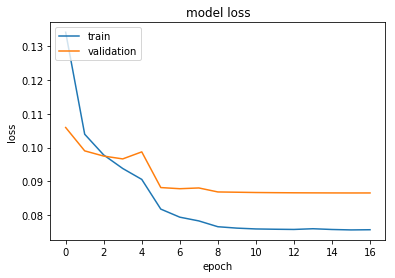

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Load Best Weights

In [11]:
model.load_weights("weights/weights.best.hdf5")

Analyze

In [13]:
from sklearn.metrics import precision_recall_fscore_support,accuracy_score
p_valid = model.predict(X_val)
precision, recall, f1 , support =  precision_recall_fscore_support(y_val, np.array(p_valid) > 0.2,average='samples')
print ("precision is ")
print (precision)
print ("recall is ")
print (recall)
print ("F1 is ")
print (f1)

precision is 
0.8806904938358744
recall is 
0.9491071428571429
F1 is 
0.9027446265032728
